In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import matplotlib.pyplot as plt
# from ptoa.data.fastmri_dataset import FastSliceDataset
import pandas as pd
import numpy as np
from pathlib import Path
from models.network import Network
import torch
from glob import glob
from torch import nn
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm

In [14]:
torch. set_grad_enabled(False)
l1 = nn.L1Loss()
l2 = nn.MSELoss()
kl = nn.KLDivLoss()
ce = nn.CrossEntropyLoss()
tx = T.ToTensor()
SMOOTH = 1

 33%|█████████████████████████████████                                                                  | 1/3 [00:00<00:00,  2.23it/s]

train_240216_translatebone_240216_155139 0.3635922968387604 0.3635922968387604


 67%|██████████████████████████████████████████████████████████████████                                 | 2/3 [00:00<00:00,  3.74it/s]

train_240216_translatebone_240218_012046 0.25343307852745056 0.25343307852745056


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.61it/s]


train_240216_translatebone_240218_141522 0.7465493679046631 0.7465493679046631


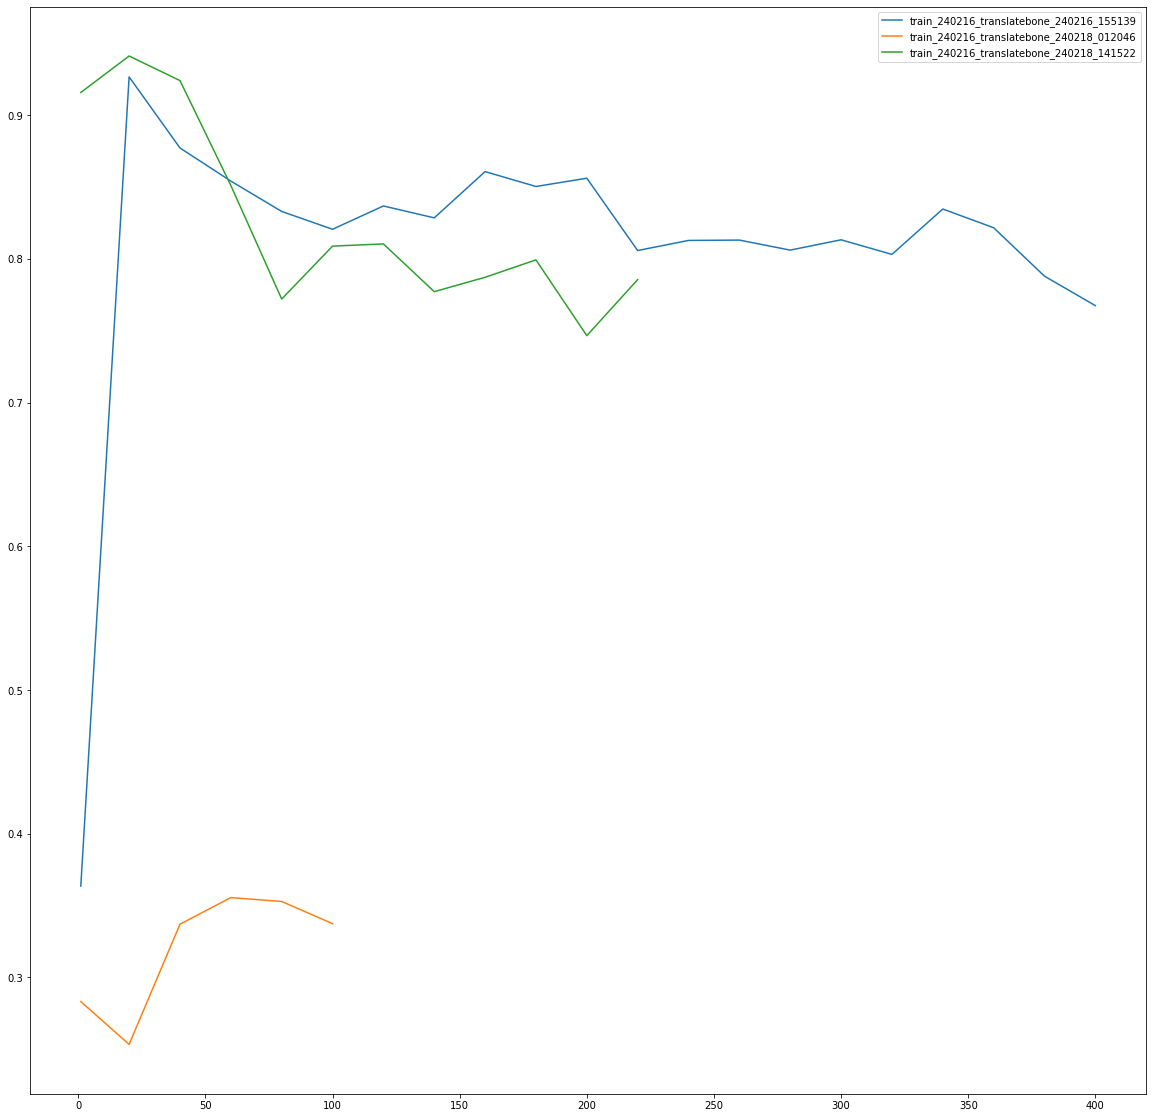

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
for ROOT in tqdm(glob('experiments/*translatebone*'), position=0):
    ROOT = ROOT + '/results/val/'
    experiment = ROOT.split('/')[-4]
    folders = glob(f"{ROOT}/*")
    folders = sorted(folders, key=lambda f: int(f.split('/')[-1]))
    ret = {}
    for folder in tqdm(folders, position=0):
        epoch = int(folder.split('/')[-1])
        pngs = [g for g in glob(f'{folder}/*') if any(x in g for x in ['GT', 'Out'])]
        slcs = set([p.split('/')[-1].replace('GT_','').replace('Out_','') for p in pngs])
        slcs = {k:
            {'gt': [p for p in pngs if k in p and 'GT' in p][0],
            'out': [p for p in pngs if k in p and 'Out' in p][0]} for k in slcs}
        l1_loss = []
        l2_loss = []
        for slc in slcs.values():
            gt_path = slc['gt']
            gt = Image.open(gt_path)
            gt_array = tx(gt)
            out_path = slc['out']
            out = Image.open(out_path)
            out_array = tx(out)
            l1_loss.append(l1(out_array, gt_array))
            l2_loss.append(l2(out_array, gt_array))
        ret[epoch] = {
            'l1_loss': torch.tensor(l1_loss).mean(),
            'l2_loss': torch.tensor(l2_loss).mean(),
        }
        # print(experiment, epoch, end='\r')

    ax.plot(ret.keys(), pd.Series([r['l1_loss'] for r in ret.values()]).rolling(window=SMOOTH).mean(), label=experiment)
    if ret:
        print(experiment, min([r['l1_loss'] for r in ret.values()]).item(), pd.Series([r['l1_loss'] for r in ret.values()]).rolling(window=SMOOTH).mean().min())    # plt.plot(ret.keys(), [r['l2_loss'] for r in ret.values()], label='l2_loss')
    # plt.title(experiment)
ax.legend()
plt.show()